### application 데이터 세트에 다양한 feature engineering 수행. 
* application_train(test) 주요 feature값들의 분포도등의 EDA 수행. 
* application_train(test) 주요 feature 들의 추가적인 가공을 통한 feature engineering 수행. 

#### 라이브러리와 app 데이터 세트 로딩

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc,os,sys
import random

from sklearn.model_selection import KFold, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 30)

#### 코랩 버전은 Google Drive에서 데이터 세트를 로딩

In [ ]:
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#### 코랩 버전은 아래와 같이 절대 경로로 디렉토리 변경. 
default_dir = "/content/gdrive/MyDrive/ML/kaggle/home-credit-default-risk/data"
app_train = pd.read_csv(os.path.join(default_dir,'application_train.csv'))
app_test = pd.read_csv(os.path.join(default_dir,'application_test.csv'))

In [ ]:
app_train.isnull().sum()

SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

In [ ]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [ ]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


#### 연속형 숫자 feature들에 대해서 TARGET값이 각각 0과 1일때의 Histogram 시각화
* violinplot과 distplot으로 숫자형 feature들에 대해 TARGET값 별 분포도 비교 시각화

In [ ]:
def show_hist_by_target(df, cols):
    cond_1 = (df['TARGET'] == 1)
    cond_0 = (df['TARGET'] == 0)

    for col in cols:
        fig, axs = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, squeeze=False)
        sns.violinplot(x='TARGET', y=col, data=df, ax=axs[0][0])
        sns.distplot(df[cond_1][col], label='1', color='red', ax=axs[0][1])
        sns.distplot(df[cond_0][col], label='0', color='blue', ax=axs[0][1])

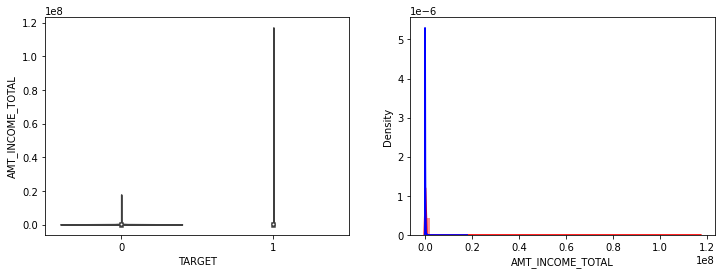

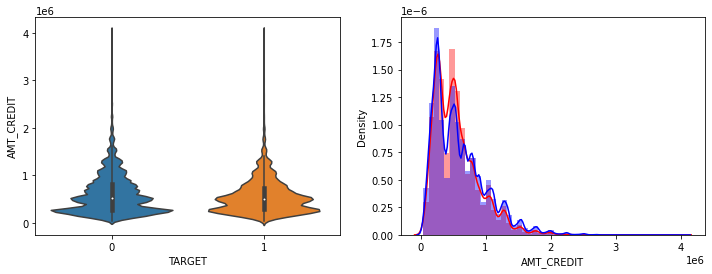

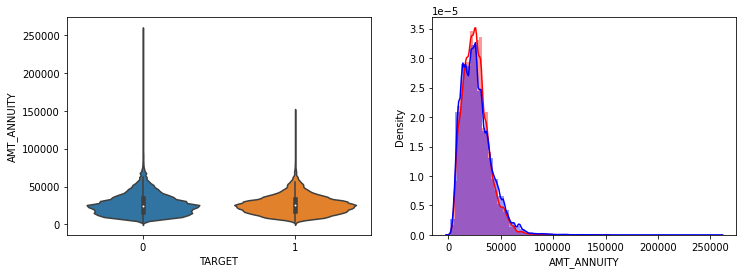

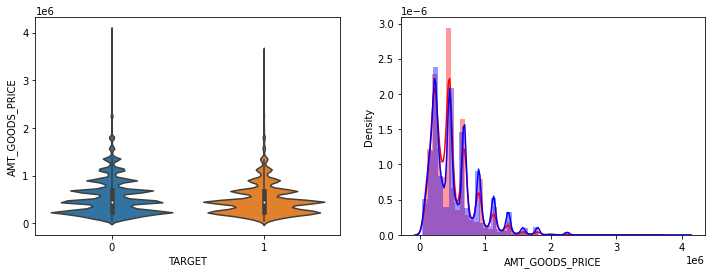

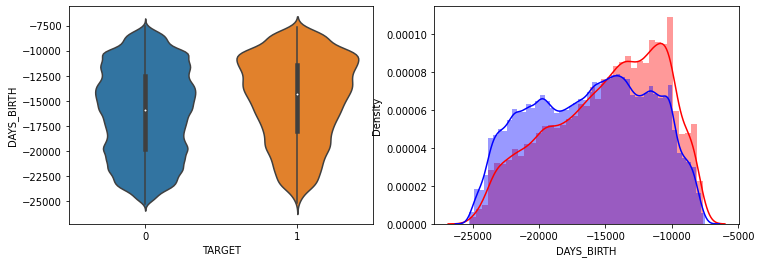

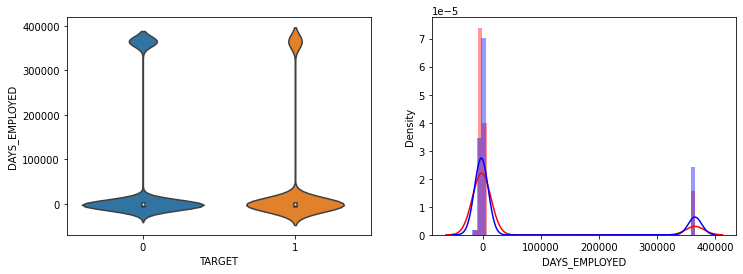

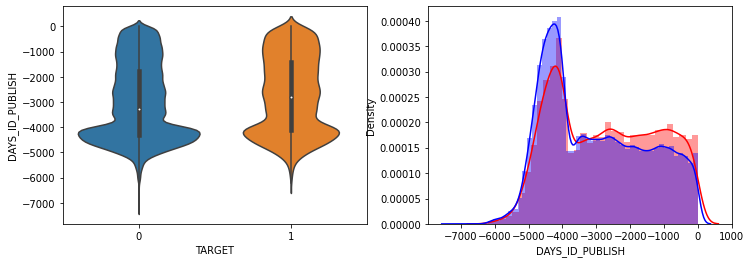

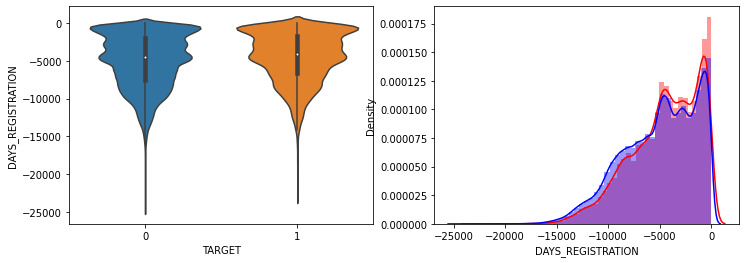

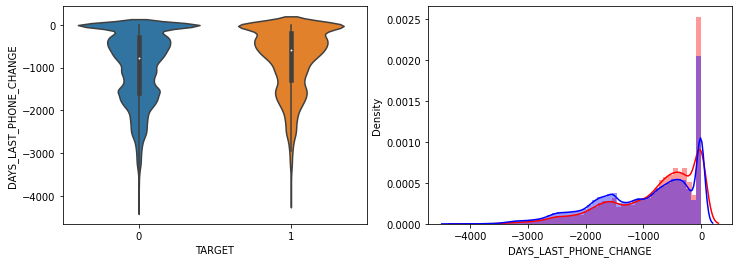

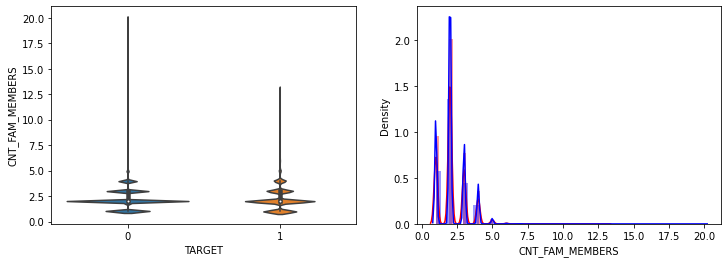

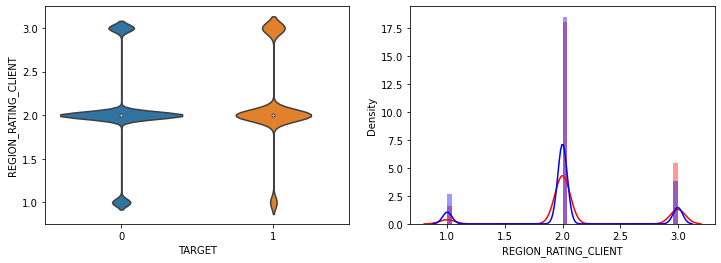

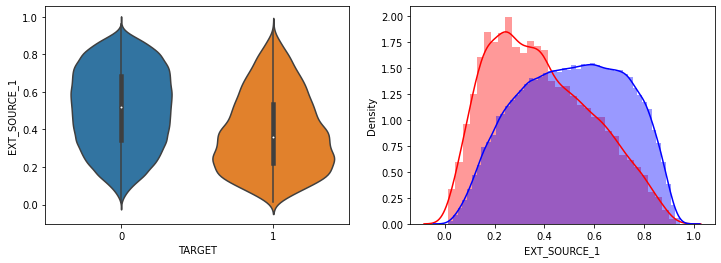

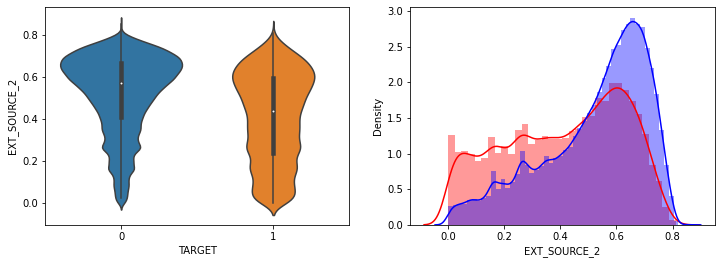

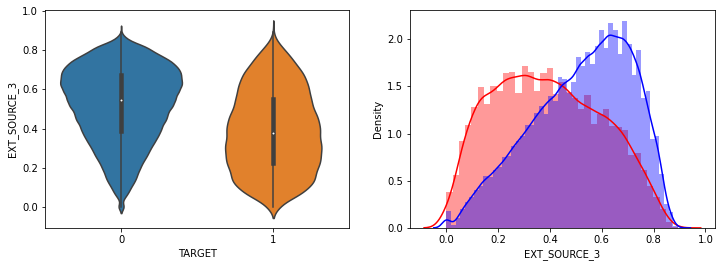

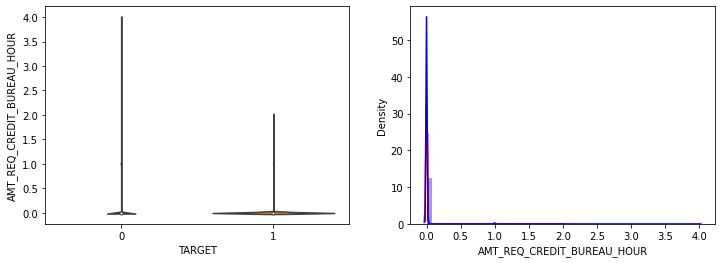

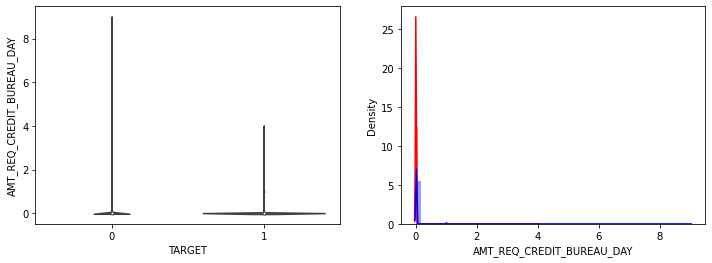

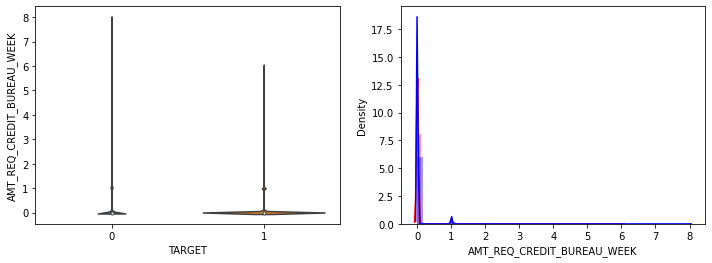

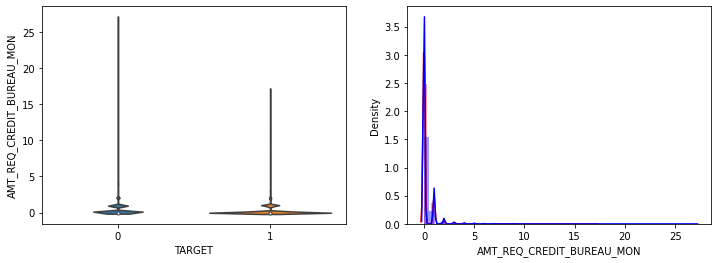

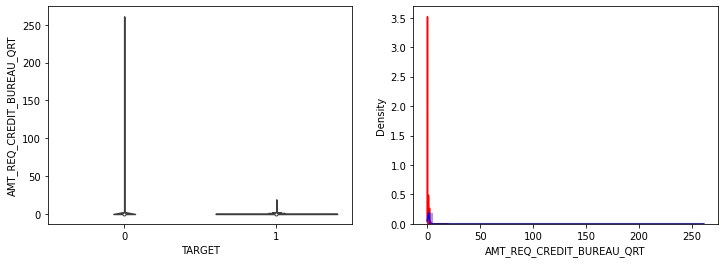

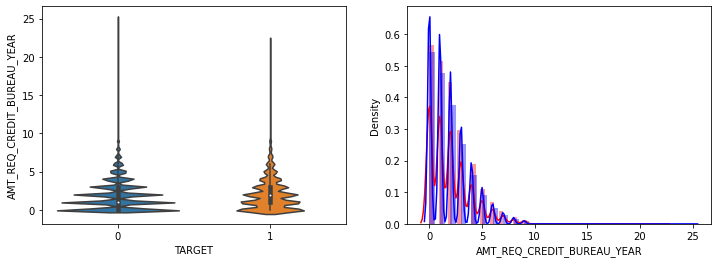

In [ ]:
columns = ['AMT_INCOME_TOTAL','AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
           'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'EXT_SOURCE_1', 
           'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 
           'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

show_hist_by_target(app_train, columns)

* AMT_INCOME_TOTAL, AMT_CREDIT 은 크게 차이가 없음. 
* AMT_ANNUITY는 TARGET=1시 상대적으로 작은 숫자대의 값이 조금 많음. 
* AMT_GOOD_PRICE는 크게 차이가 없음. 
* DAYS_BIRTH는 TARGET=1시 적은 연령대의 숫자값이 상대적으로 많음. 
* DAYS_EMPLOYED는 TARGET=1시 작은 값들이 조금 더 많음. 
* DAYS_ID_PUBLISH, DAYS_REGISTRATION  는 TARGET=1시 최근 값들이 조금 더 많음. 
* DAYS_LAST_PHONE_CHANGE는 큰 차이 없음. 
* CNT_FAM_MEMBERS는 차이가 없음. outlier 때문에 histogram에 차이가 있어 보임. 
* REGION_RATING_CLIENT는 큰 차이 없음 
* EXT_SOURCE_1,EXT_SOURCE_2, EXT_SOURCE_3 모두 조금씩 차이가 있음.  
* 나머지 컬럼모두 큰 차이가 없음. 
* 전반적으로 연령대가 낮은(직장 경력이 적은), 소액 대출에서 상대적으로 연체 비중이 높음.  

#### seaborn의 countplot() 또는 catplot()을 이용하여 category 피처(object 컬럼)을 TARGET 유형에 따라 Count 비교

In [ ]:
object_columns = app_train.dtypes[app_train.dtypes == 'object'].index.tolist()

In [ ]:
object_columns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [ ]:
def show_count_by_target(df, cols):
    cond_0 = (df['TARGET'] == 0)
    cond_1 = (df['TARGET'] == 1)

    for col in cols:
        print('column name: ', col)
        fig, axs = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, squeeze=False)
        sns.countplot(df[cond_0][col], ax=axs[0][0])
        sns.countplot(df[cond_1][col], ax=axs[0][1])

In [ ]:
show_count_by_target(app_train, object_columns)

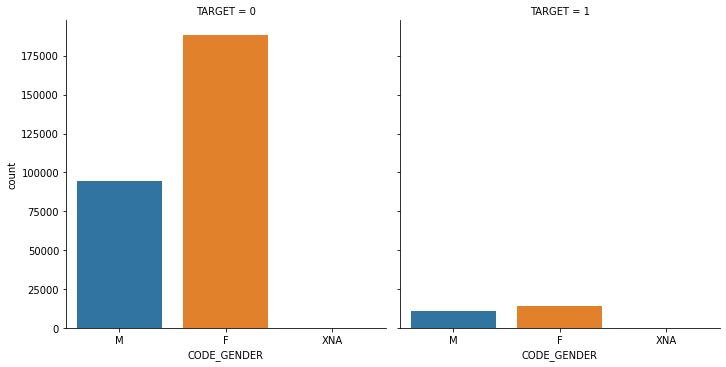

In [ ]:
sns.catplot(x='CODE_GENDER', col='TARGET', data=app_train, kind='count')

In [ ]:
def show_category_by_target(df, cols):
    for col in cols:
        print('column name: ', col)
        chart = sns.catplot(x=col, col='TARGET', data=df, kind='count')
        chart.set_xticklabels(rotation=65)

column name:  NAME_CONTRACT_TYPE
column name:  CODE_GENDER
column name:  FLAG_OWN_CAR
column name:  FLAG_OWN_REALTY
column name:  NAME_TYPE_SUITE
column name:  NAME_INCOME_TYPE
column name:  NAME_EDUCATION_TYPE
column name:  NAME_FAMILY_STATUS
column name:  NAME_HOUSING_TYPE
column name:  OCCUPATION_TYPE
column name:  WEEKDAY_APPR_PROCESS_START
column name:  ORGANIZATION_TYPE
column name:  FONDKAPREMONT_MODE
column name:  HOUSETYPE_MODE
column name:  WALLSMATERIAL_MODE
column name:  EMERGENCYSTATE_MODE


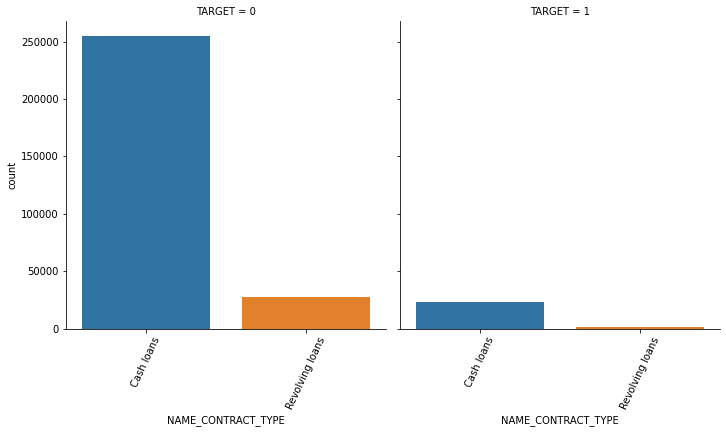

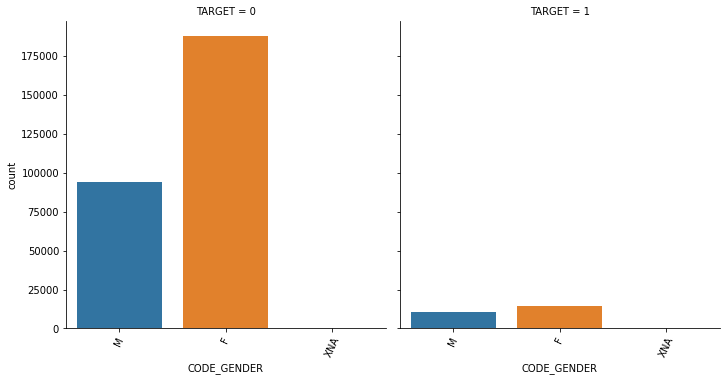

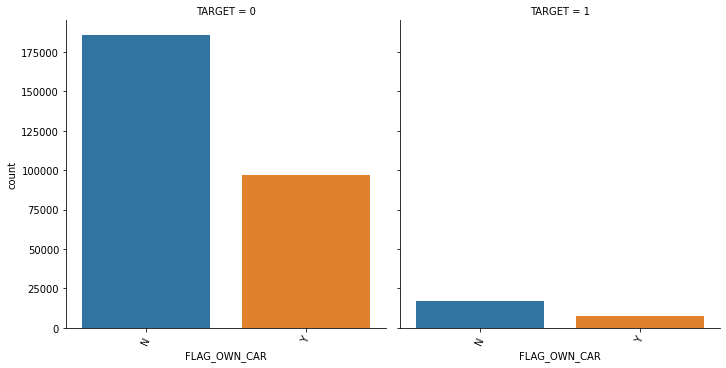

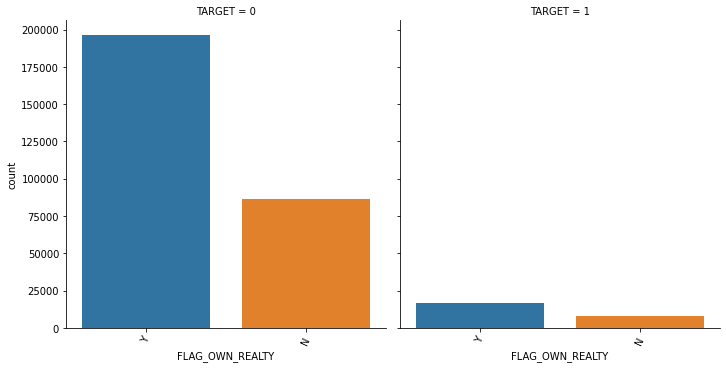

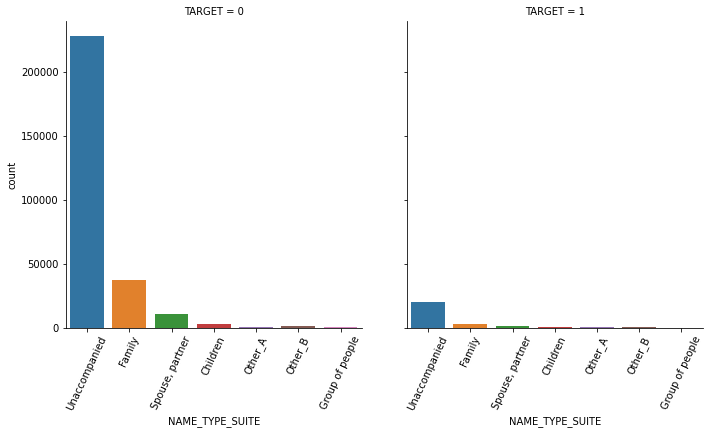

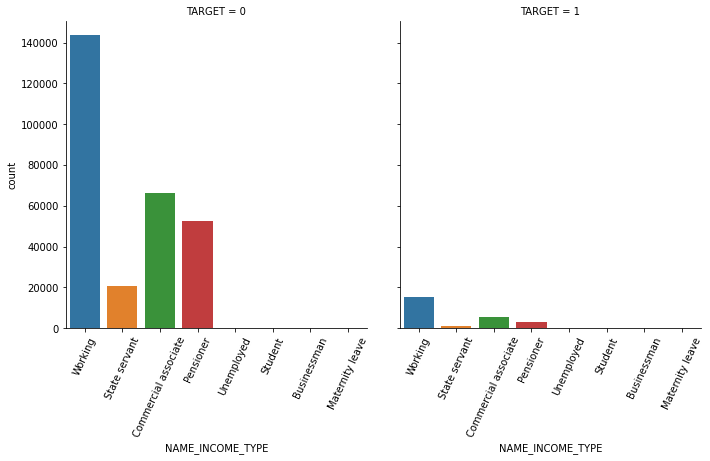

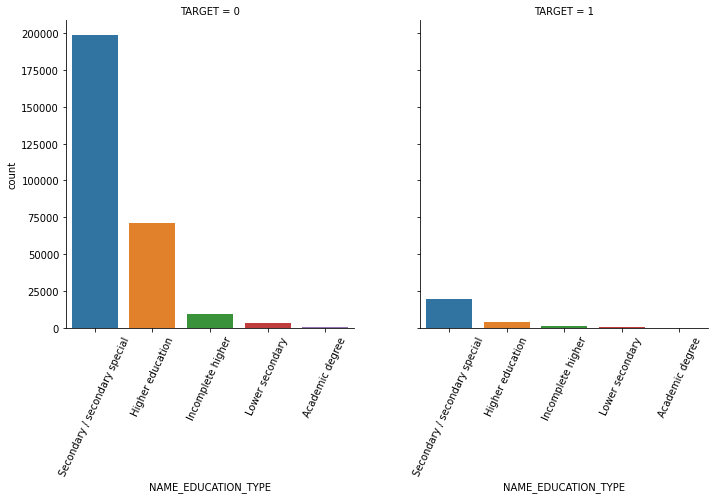

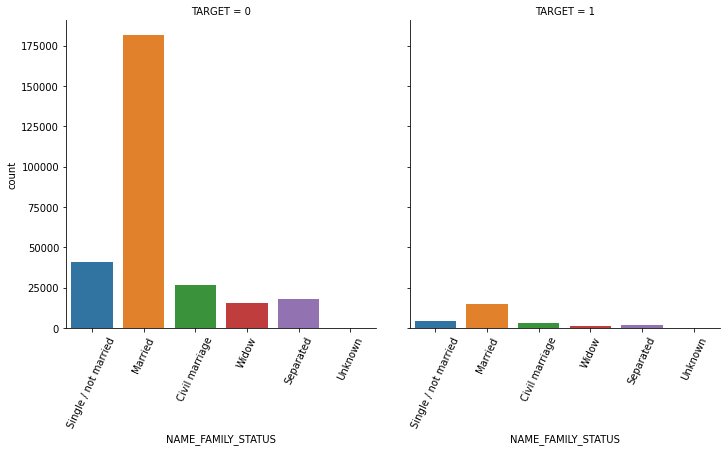

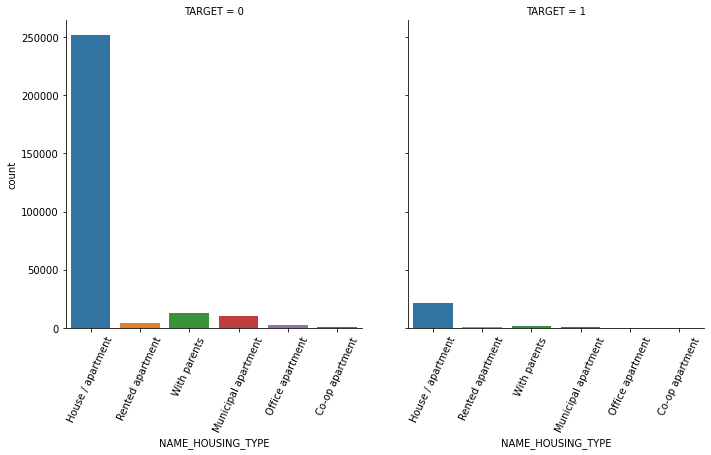

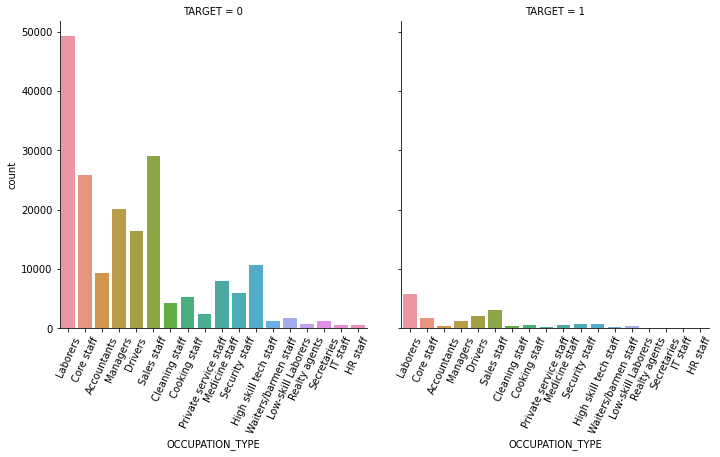

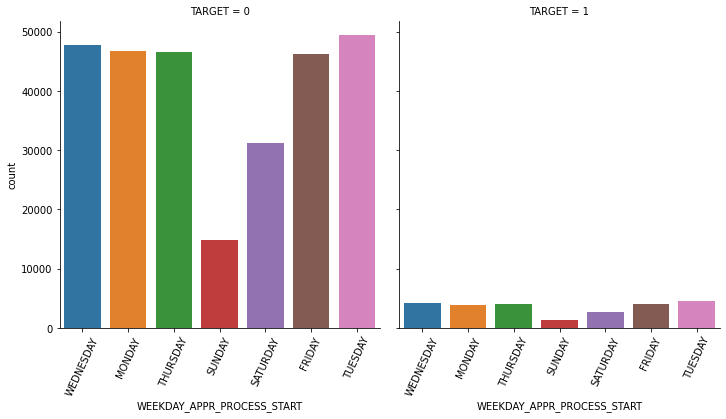

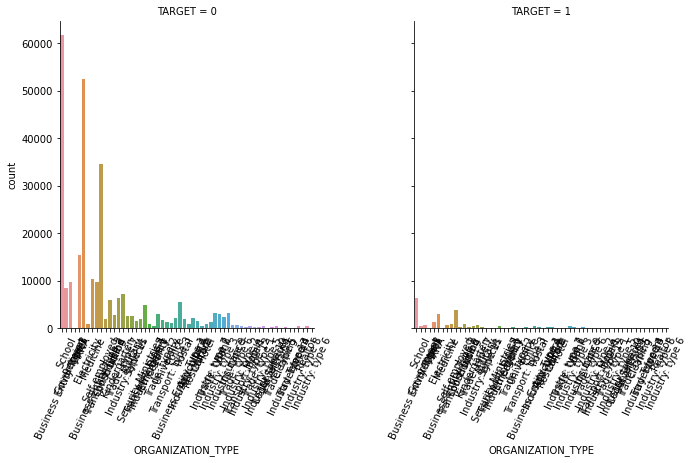

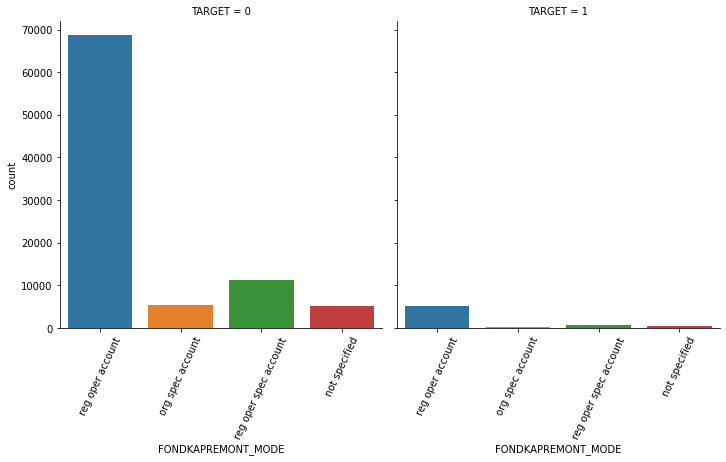

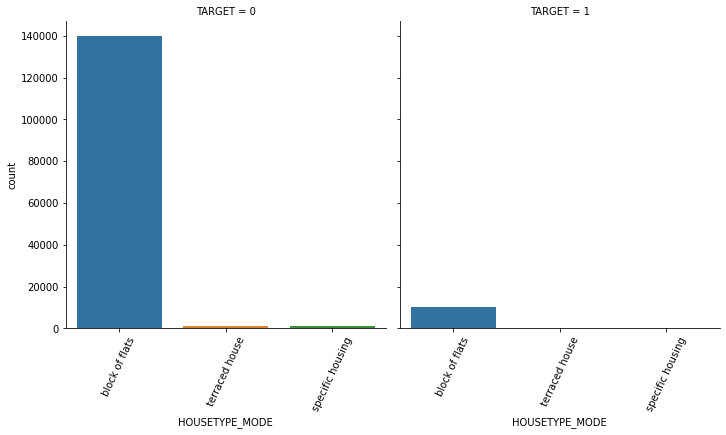

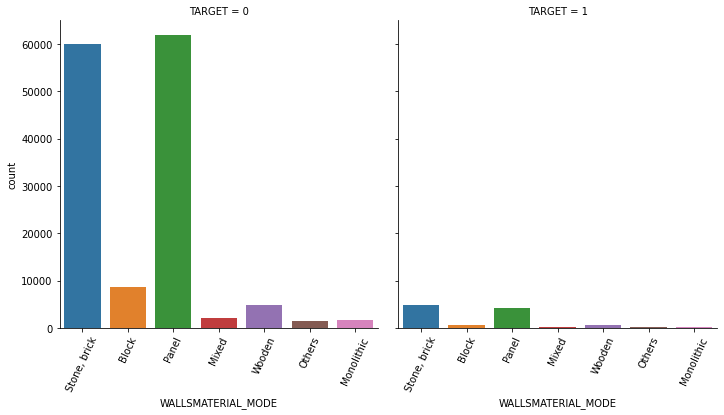

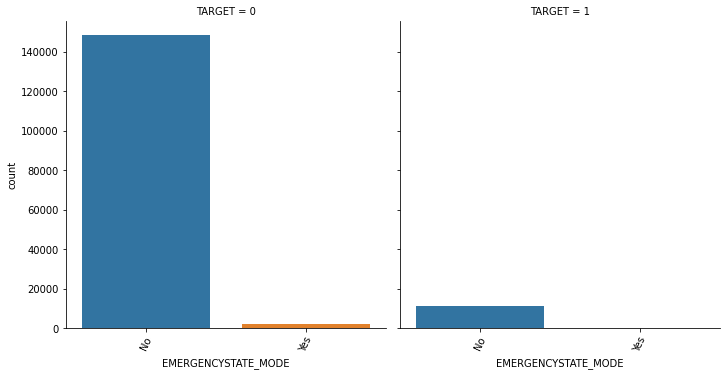

In [ ]:
show_category_by_target(app_train, object_columns)

#### 대출 횟수 대비 연체 비율이 남성이 여성보다 높음. 이를 value_counts()로 확인. 

In [ ]:
cond_1 = (app_train['TARGET'] == 1)
cond_0 = (app_train['TARGET'] == 0)

print(app_train['CODE_GENDER'].value_counts() / app_train.shape[0])
print(app_train[cond_1]['CODE_GENDER'].value_counts() / app_train[cond_1].shape[0])
print(app_train[cond_0]['CODE_GENDER'].value_counts() / app_train[cond_0].shape[0])

F      0.658344
M      0.341643
XNA    0.000013
Name: CODE_GENDER, dtype: float64
F    0.570796
M    0.429204
Name: CODE_GENDER, dtype: float64
F      0.666032
M      0.333954
XNA    0.000014
Name: CODE_GENDER, dtype: float64


#### 주요 컬럼들의 target과의 상관도 분석
  - heatmap : 연속형 변수 상관도 분석

In [ ]:
corr_columns = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
               'DAYS_EMPLOYED','DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE', 'AMT_INCOME_TOTAL', 'TARGET']

col_corr = app_train[corr_columns].corr()
col_corr

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,AMT_INCOME_TOTAL,TARGET
EXT_SOURCE_1,1.000000,0.213982,0.186846,-0.600610,0.168429,0.119398,0.175502,0.289848,-0.132375,-0.181095,-0.132607,0.026232,-0.155317
EXT_SOURCE_2,0.213982,1.000000,0.109167,-0.091996,0.131228,0.125804,0.139367,-0.020767,-0.050955,-0.059913,-0.195764,0.060925,-0.160472
EXT_SOURCE_3,0.186846,0.109167,1.000000,-0.205478,0.043516,0.030752,0.047717,0.113434,-0.131597,-0.107549,-0.075256,-0.030229,-0.178919
DAYS_BIRTH,-0.600610,-0.091996,-0.205478,1.000000,-0.055436,0.009445,-0.053442,-0.615864,0.272691,0.331912,0.082939,0.027261,0.078239
AMT_CREDIT,0.168429,0.131228,0.043516,-0.055436,1.000000,0.770138,0.986968,-0.066838,-0.006575,0.009621,-0.073701,0.156870,-0.030369
AMT_ANNUITY,0.119398,0.125804,0.030752,0.009445,0.770138,1.000000,0.775109,-0.104332,0.011268,0.038514,-0.063747,0.191657,-0.012817
AMT_GOODS_PRICE,0.175502,0.139367,0.047717,-0.053442,0.986968,0.775109,1.000000,-0.064842,-0.009267,0.011565,-0.076313,0.159610,-0.039645
DAYS_EMPLOYED,0.289848,-0.020767,0.113434,-0.615864,-0.066838,-0.104332,-0.064842,1.000000,-0.272378,-0.210242,0.023032,-0.064223,-0.044932
DAYS_ID_PUBLISH,-0.132375,-0.050955,-0.131597,0.272691,-0.006575,0.011268,-0.009267,-0.272378,1.000000,0.101896,0.088576,0.008506,0.051457
DAYS_REGISTRATION,-0.181095,-0.059913,-0.107549,0.331912,0.009621,0.038514,0.011565,-0.210242,0.101896,1.000000,0.056983,0.027805,0.041975


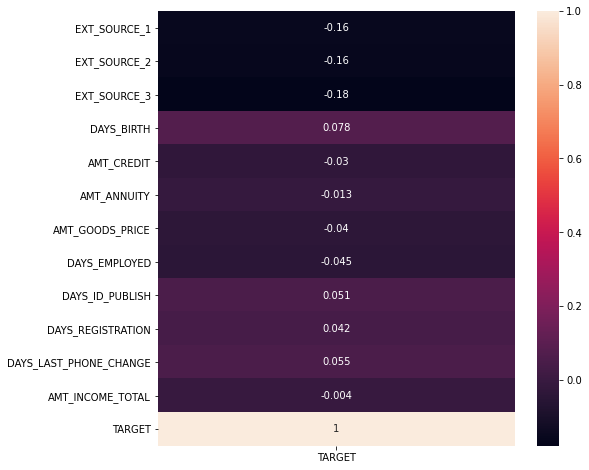

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(col_corr[['TARGET']], annot=True)

#### 이상치 데이터 확인 및 DAYS_EMPLOYED 이상치 값 변경 

In [ ]:
app_train['DAYS_EMPLOYED'].value_counts()

 365243    55374
-200         156
-224         152
-199         151
-230         151
           ...  
-11115         1
-11371         1
-11883         1
-13536         1
-8795          1
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

In [ ]:
app_train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [ ]:
app_train['DAYS_EMPLOYED'] = app_train['DAYS_EMPLOYED'].replace(365243, np.nan)
app_train['DAYS_EMPLOYED'].value_counts(dropna=False)

 NaN        55374
-200.0        156
-224.0        152
-199.0        151
-230.0        151
            ...  
-8868.0         1
-13006.0        1
-10261.0        1
-14079.0        1
-9062.0         1
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

### 주요 Feature들에 대한 feature engineering 수행

#### EXT_SOURCE 계열값 확인, EXT_SOURCE_X 피처들의 평균/최대/최소/표준편차 확인 

In [ ]:
app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].isnull().sum()

EXT_SOURCE_1    173378
EXT_SOURCE_2       660
EXT_SOURCE_3     60965
dtype: int64

In [ ]:
app_train['EXT_SOURCE_1'].value_counts(dropna=False)

NaN         173378
0.546426         5
0.598469         5
0.499002         5
0.605152         5
             ...  
0.381263         1
0.259241         1
0.116346         1
0.171978         1
0.844540         1
Name: EXT_SOURCE_1, Length: 114585, dtype: int64

In [ ]:
app_train['EXT_SOURCE_2'].value_counts(dropna=False)

0.285898    721
NaN         660
0.262258    417
0.265256    343
0.159679    322
           ... 
0.383020      1
0.786006      1
0.256132      1
0.297243      1
0.336367      1
Name: EXT_SOURCE_2, Length: 119832, dtype: int64

In [ ]:
app_train['EXT_SOURCE_3'].value_counts(dropna=False)

NaN         60965
0.746300     1460
0.713631     1315
0.694093     1276
0.670652     1191
            ...  
0.887664        1
0.879506        1
0.020311        1
0.849170        1
0.014556        1
Name: EXT_SOURCE_3, Length: 815, dtype: int64

In [ ]:
# EXT_SOURCE_X 피처들의 평균/최대/최소/표준편차 확인 
print('### mean ###\n', app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean())
print('### max ###\n',app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max())
print('### min ###\n',app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].min())
print('### std ###\n',app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std())

### mean ###
 EXT_SOURCE_1    0.502130
EXT_SOURCE_2    0.514393
EXT_SOURCE_3    0.510853
dtype: float64
### max ###
 EXT_SOURCE_1    0.962693
EXT_SOURCE_2    0.855000
EXT_SOURCE_3    0.896010
dtype: float64
### min ###
 EXT_SOURCE_1    1.456813e-02
EXT_SOURCE_2    8.173617e-08
EXT_SOURCE_3    5.272652e-04
dtype: float64
### std ###
 EXT_SOURCE_1    0.211062
EXT_SOURCE_2    0.191060
EXT_SOURCE_3    0.194844
dtype: float64


#### 데이터 가공 전 학습과 테스트용 데이터 세트 결합

In [ ]:
apps = pd.concat([app_train, app_test])
print(apps.shape)

(356255, 122)


#### EXT_SOURCE_X FEATURE 가공
* EXT_SOURCE_X 피처들을 결합하여 평균과 표준 편차를 신규 생성. 

In [ ]:
apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

In [ ]:
apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)

In [ ]:
apps.iloc[:, -2:].head(10)

,APPS_EXT_SOURCE_MEAN,APPS_EXT_SOURCE_STD
0,0.161787,0.092026
1,0.466757,0.219895
2,0.642739,0.122792
3,0.650442,NaN
4,0.322738,NaN
5,0.487726,0.188799
6,0.663607,0.150717
7,0.627467,0.122771
8,0.514935,0.280096
9,0.746644,NaN


In [ ]:
# std 결측치 처리
apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())

#### AMT_CREDIT 비율로 Feature 가공

In [ ]:
apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY'] / apps['AMT_CREDIT']  # 총 대출 금액 대비 월 대출 지급액
apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE'] / apps['AMT_CREDIT']  # 총 대출 금액 대비 대출 상품 가격
apps['APPS_CREDIT_GOODS_DIFF'] = apps['AMT_CREDIT'] - apps['AMT_GOODS_PRICE']  

#### AMT_INCOME_TOTAL 비율로 Feature 가공

In [ ]:
# AMT_INCOME_TOTAL 비율로 대출 금액 관련 피처 가공
apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY'] / apps['AMT_INCOME_TOTAL']
apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT'] / apps['AMT_INCOME_TOTAL']
apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE'] / apps['AMT_INCOME_TOTAL']

# 가족수를 고려한 가처분 소득 피처 가공. 
apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL'] / apps['CNT_FAM_MEMBERS']

#### DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공.

In [ ]:
# DAYS_BIRTH, DAYS_EMPLOYED 비율로 소득/자산 관련 Feature 가공. 
apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED'] / apps['DAYS_BIRTH']
apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL'] / apps['DAYS_EMPLOYED']
apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL'] / apps['DAYS_BIRTH']
apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']

#### 데이터 레이블 인코딩, NULL값은 LightGBM 내부에서 처리하도록 특별한 변경하지 않음. 

In [ ]:
object_columns = apps.dtypes[apps.dtypes == 'object'].index.tolist()

In [ ]:
for col in object_columns:
    apps[col] = pd.factorize(apps[col])[0]

#### 학습 데이터와 테스트 데이터 다시 분리

In [ ]:
apps_train = apps[~apps['TARGET'].isnull()]
apps_test = apps[apps['TARGET'].isnull()]
apps.shape, apps_train.shape, apps_test.shape

((356255, 136), (307511, 136), (48744, 136))

#### 학습 데이터를 검증 데이터로 분리하고 LGBM Classifier로 학습 수행. 

In [ ]:
from sklearn.model_selection import train_test_split

ftr_app = apps_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
target_app = app_train['TARGET']

train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
train_x.shape, valid_x.shape

((215257, 134), (92254, 134))

In [ ]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
        early_stopping_rounds= 100)

Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.247527	training's auc: 0.759999	valid_1's binary_logloss: 0.249532	valid_1's auc: 0.749382
[200]	training's binary_logloss: 0.240419	training's auc: 0.780752	valid_1's binary_logloss: 0.245559	valid_1's auc: 0.759704
[300]	training's binary_logloss: 0.235847	training's auc: 0.794946	valid_1's binary_logloss: 0.244186	valid_1's auc: 0.763743
[400]	training's binary_logloss: 0.2321	training's auc: 0.806864	valid_1's binary_logloss: 0.243695	valid_1's auc: 0.765196
[500]	training's binary_logloss: 0.2288	training's auc: 0.817393	valid_1's binary_logloss: 0.243586	valid_1's auc: 0.765379
[600]	training's binary_logloss: 0.225638	training's auc: 0.827276	valid_1's binary_logloss: 0.243474	valid_1's auc: 0.765683
[700]	training's binary_logloss: 0.22271	training's auc: 0.835886	valid_1's binary_logloss: 0.243401	valid_1's auc: 0.765848
[800]	training's binary_logloss: 0.219855	training's auc: 0.

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.02, max_depth=12,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=32, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=-1,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0,
               verbose=-1)

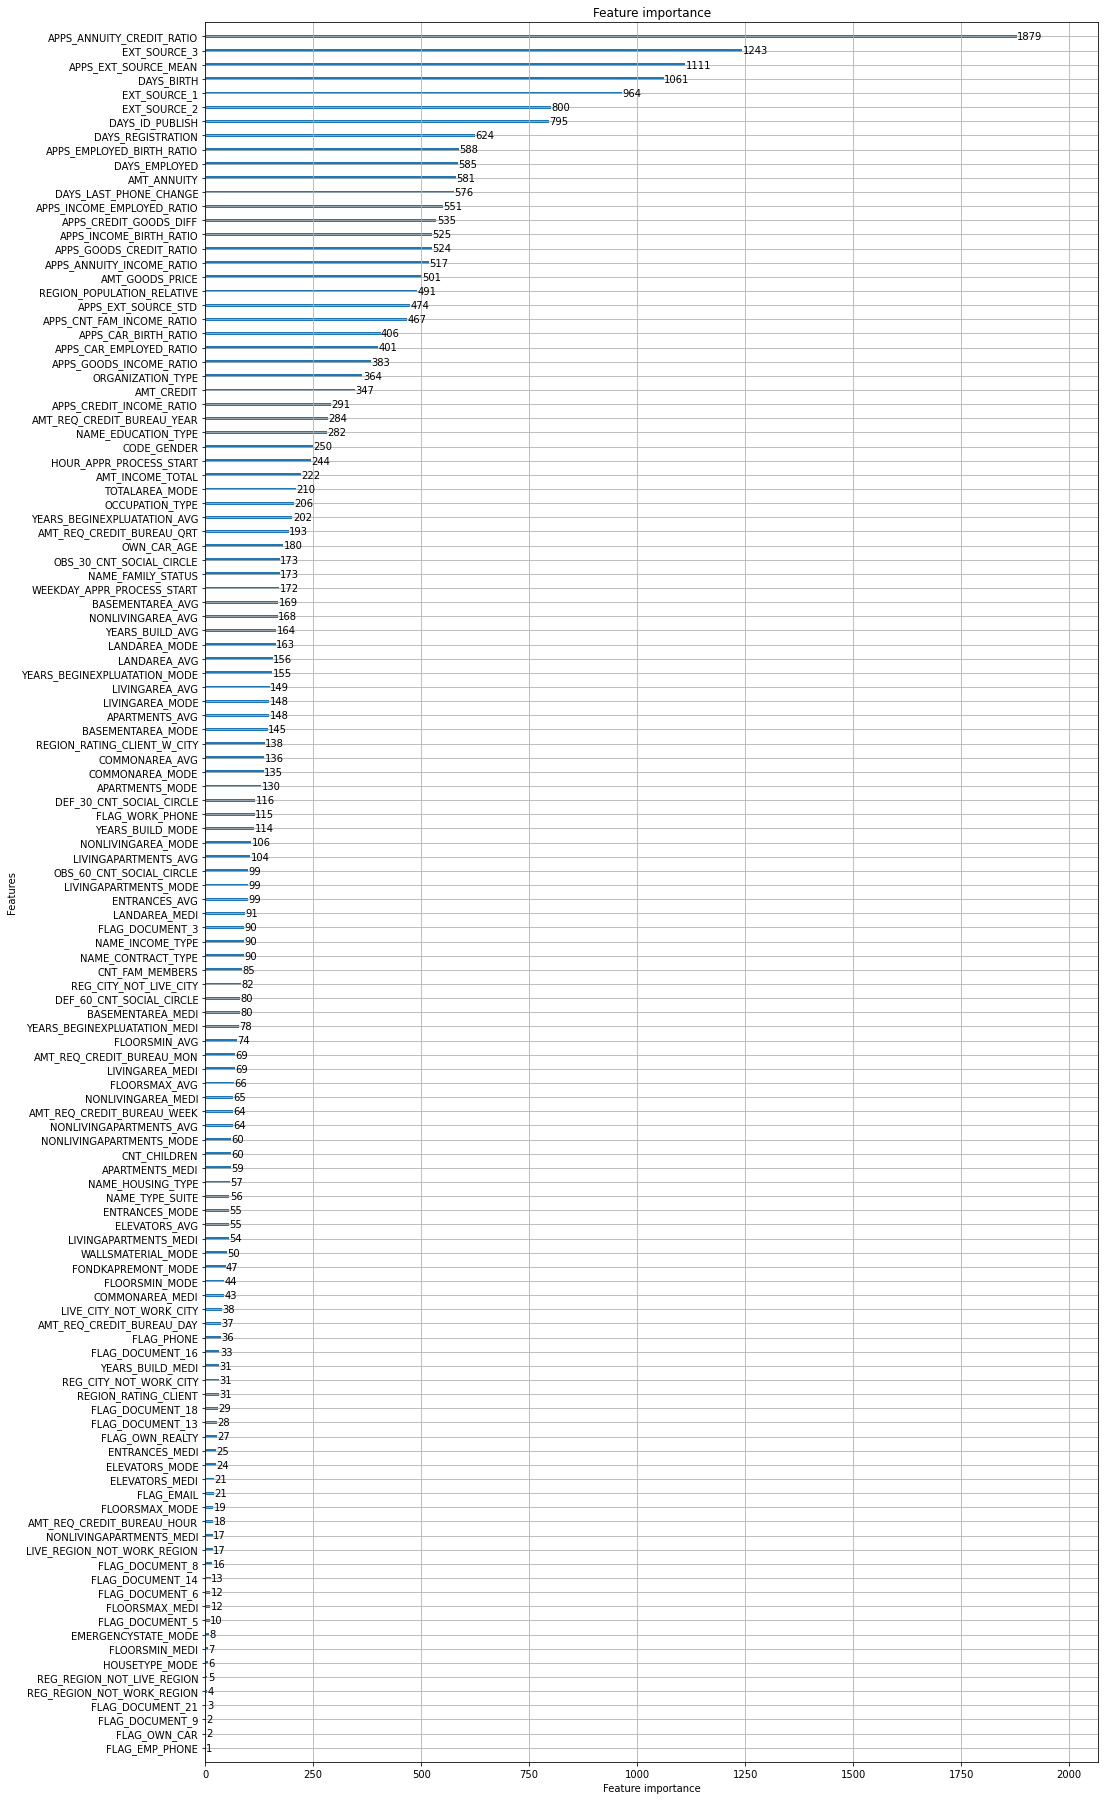

In [ ]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32))

#### 학습된 Classifier를 이용하여 테스트 데이터 예측하고 결과를 Kaggle로 Submit 수행. 

In [ ]:
preds = clf.predict_proba(apps_test.drop(['SK_ID_CURR', 'TARGET'], axis=1))[:, 1]
app_test['TARGET'] = preds

In [ ]:
app_test[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(default_dir,'apps_baseline_02_01.csv'), index=False)

##### 코랩 버전은 Google Drive로 예측 결과 CSV를 생성.

In [ ]:
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

In [ ]:
# SK_ID_CURR과 TARGET 값만 csv 형태로 생성. 코랩 버전은 구글 드라이브 절대 경로로 입력  
default_dir = "/content/gdrive/My Drive"
app_test[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(default_dir,'apps_baseline_02_01.csv'), index=False)